In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications import MobileNetV2
import mrcnn.model as modellib
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [4]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [5]:
imagePaths = list(paths.list_images('data'))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode="nearest")

In [7]:
baseModel = modellib.MaskRCNN(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


D:\ProgramData\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

H = model.fit(aug.flow(trainX, trainY, batch_size=BS),steps_per_epoch=len(trainX) // BS,validation_data=(testX, testY),validation_steps=len(testX) // BS,epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
35/35 [==============================] - 126s 4s/step - loss: 0.7068 - acc: 0.6509 - val_loss: 0.2721 - val_acc: 0.9130
Epoch 2/20
35/35 [==============================] - 129s 4s/step - loss: 0.4203 - acc: 0.8136 - val_loss: 0.1907 - val_acc: 0.9457
Epoch 3/20
35/35 [==============================] - 129s 4s/step - loss: 0.2933 - acc: 0.8791 - val_loss: 0.1293 - val_acc: 0.9601
Epoch 4/20
35/35 [==============================] - 128s 4s/step - loss: 0.2335 - acc: 0.9145 - val_loss: 0.0914 - val_acc: 0.9819
Epoch 5/20
35/35 [==============================] - 133s 4s/step - loss: 0.2019 - acc: 0.9236 - val_loss: 0.0793 - val_acc: 0.9783
Epoch 6/20
35/35 [==============================] - 145s 4s/step - loss: 0.1661 - acc: 0.9300 - val_loss: 0.0791 - val_acc: 0.9819
Epoch 7/20
35/35 [==============================] - 140s 4s/step - loss: 0.1547 - acc: 0.9382 - val_loss: 0.0799 - v

In [10]:
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

model.save('mask_detector.model')

[INFO] evaluating network...
                   precision    recall  f1-score   support

   data/with_mask       0.98      1.00      0.99       138
data/without_mask       1.00      0.98      0.99       138

         accuracy                           0.99       276
        macro avg       0.99      0.99      0.99       276
     weighted avg       0.99      0.99      0.99       276

[INFO] saving mask detector model...


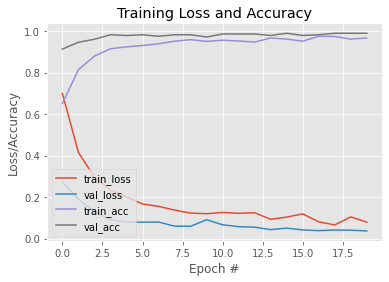

In [13]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('plot.png')